# Анализ оттока клиентов из сети фитнес центров

**Описание проекта**

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства; 

проанализировать основные признаки, наиболее сильно влияющие на отток; 

сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

**Описание данных**

 - 'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете:

Данные клиента за предыдущий до проверки факта оттока месяц:

 - 'gender' — пол;

 - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;

 - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
 
 - 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);

 - 'Phone' — наличие контактного телефона;
 
 - 'Age' — возраст;
 
 - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

 
 - 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
 
 - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
 
 - 'Group_visits' — факт посещения групповых занятий;
 
 - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
 
 - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
 
 - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

## Загрузим данные

In [359]:
#импортируем необходимые библиотеки
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
from plotly import graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [360]:
#прочитаем таблицу и сохраним ее в переменную df

df = pd.read_csv('/datasets/gym_churn.csv')

In [361]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [362]:
#Преведем названия столбцов к нижнему регистру 
df.columns = df.columns.str.lower()

## Проведем исследовательский анализ данных (EDA)

In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [364]:
#проверим на дубликаты
df.duplicated().sum()

0

Дубликатов и пропусков нет.

### Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения

In [365]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Из таблицы видим, что: 

Почти у 85% клиентов фитнес центр находится рядом с работой или домом, 

примерно 41% клиентов посещают групповые занятия, 

31% пришли по рекомендации друзей. 

Средний возраст клиентов - 29 лет,зал посещают люди от 18 до 41 года и в гендерном соотношении разделены практически одинаково. 

Почти половина клиентов - сотрудники компании-партнёра клуба. 

Факт оттока в текущем месяце зафиксирован у 27% клиентов.

###  Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [366]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Клиенты в оттоке это те, кто живут не очень близко, пришли на пробный период-месяц,не имели каких-либо предложений по скидкам/партнерским программам,почти не посещали групповых занятий.

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

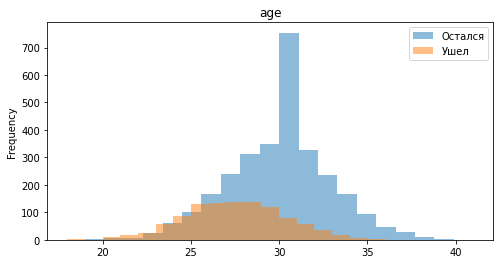

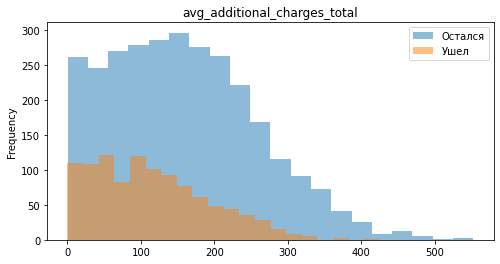

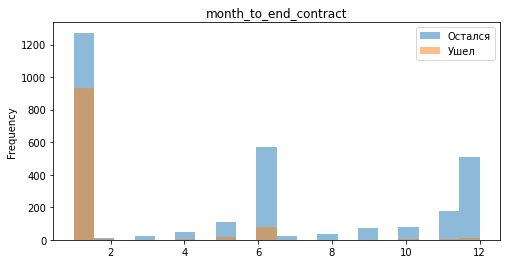

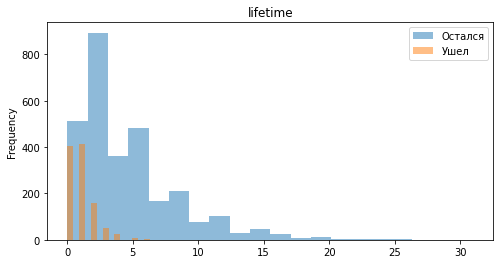

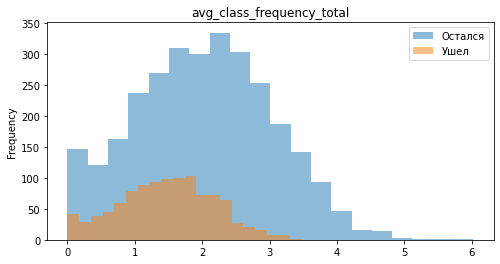

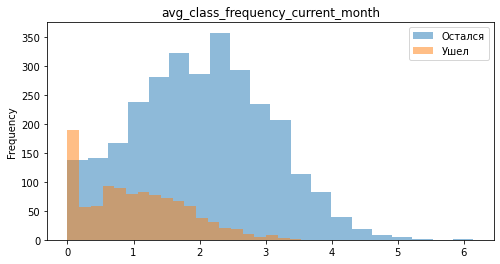

In [367]:
# Изучим гистограммы небинарных признаков
for col in ['age',
     'avg_additional_charges_total',
     'month_to_end_contract',
     'lifetime',
     'avg_class_frequency_total',
     'avg_class_frequency_current_month']:
    df.groupby('churn')[col].plot.hist(alpha=0.5, legend=True, bins=20, figsize=(8,4))
    plt.legend(['Остался', 'Ушел'])
    plt.title(col)
    plt.show()       


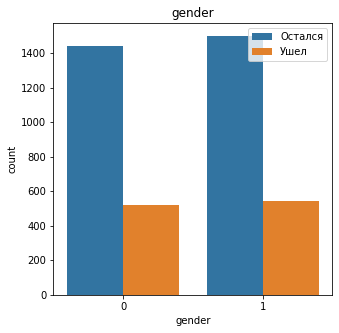

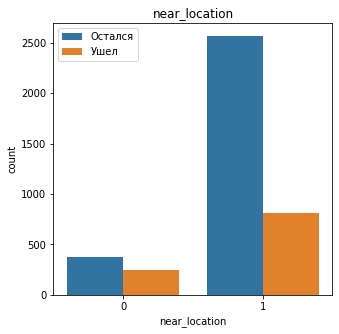

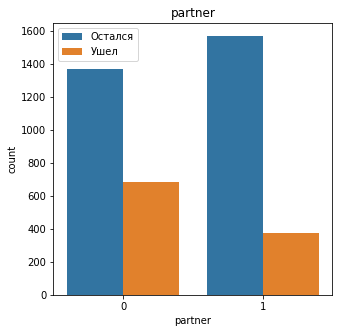

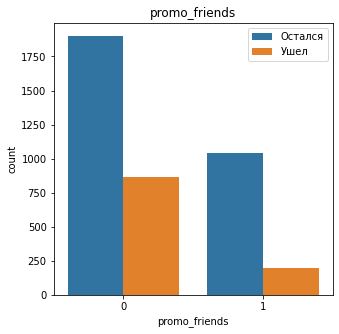

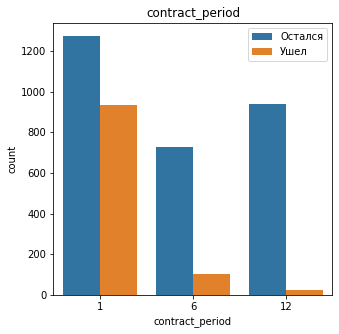

In [368]:
# Изучим гистограммы бинарных признаков
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'contract_period']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = df[column], hue='churn', data=df)
    plt.legend(['Остался', 'Ушел']);
    plt.title(column)
    plt.show()

Выводы:

phone, gender - по данным категориям нет видимых отличий.

near_location - доля ушедших посетителей из соседних районов выше, чем тех кто остался.

partner - доля ушедших посетителей-партнеров меньше, чем у посетителей не партнеров.

promo_friends - график показывает,что пришедших по акции уходит меньше,тех кто пришел сам - уходит больше.

contract_period - В графике есть закономерность - чем больше период посещения, тем меньше уходят клиеты.

group_visits - Из групповых занятий клиенты уходят меньше.

age -  Посетители которые уходят немного моложе. 

avg_additional_charges_total - Ушедшие клиенты тратят меньше, чем те кто остался.

lifetime -Больше клиентов уходит после первых месяцев посещений.

month_to_end_contract -Чем дольше клиет остаётся, тем меньше шансов у него уйти.

avg_class_frequency_total - График подтверждает, что ушедшие посетители реже (в неделю) посещают спорт зал. 

avg_class_frequency_current_month - у ушедших клиентов смещение в сторону 0-1 раза в неделю,за прошдый месяц.

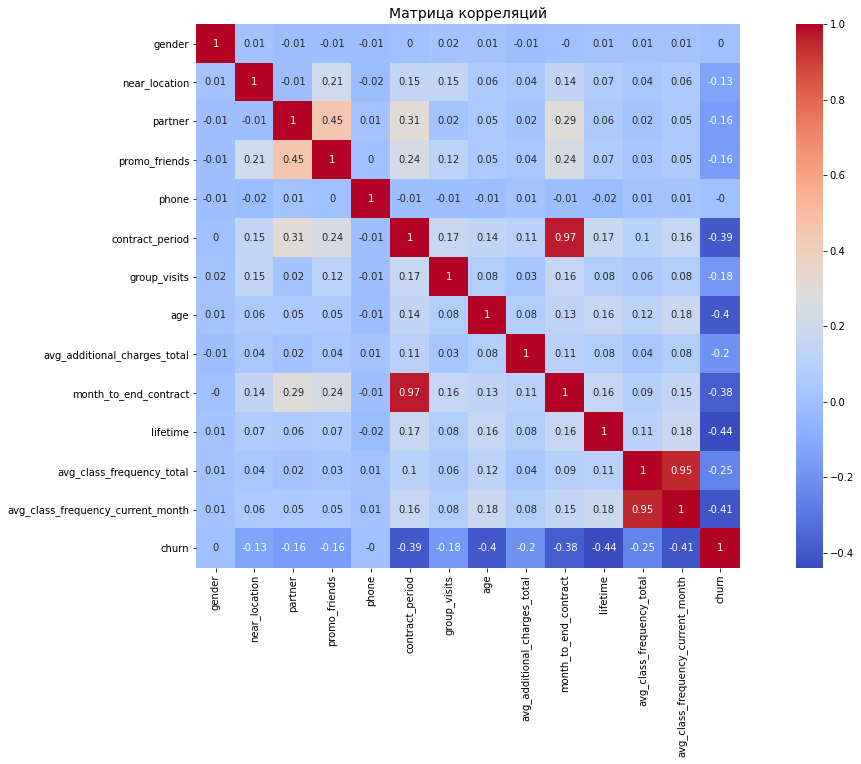

In [369]:
# построим матрицу корреляций
plt.figure(figsize=(20,10))
sns.heatmap(df.corr().round(2), annot=True, square=True, cmap='coolwarm')
plt.title('Матрица корреляций', fontsize=14)
plt.show()

по матрице коррелиции сильную зависимость наблюдаем только у 

'contract_period' - 'month_to_end_contract' и 'avg_class_frequency_total' - 'avg_class_frequency_current_month'.

Во избежание мультиколлинеарности, удалим из датафрейма один из них- 'month_to_end_contract' и 'avg_class_frequency_current_month'.

In [370]:
df.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis=1, inplace=True)
df.head().T

,0,1,2,3,4
gender,1.000000,0.000000,0.000000,0.000000,1.000000
near_location,1.000000,1.000000,1.000000,1.000000,1.000000
partner,1.000000,0.000000,1.000000,1.000000,1.000000
promo_friends,1.000000,0.000000,0.000000,1.000000,1.000000
phone,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,6.000000,12.000000,1.000000,12.000000,1.000000
group_visits,1.000000,1.000000,0.000000,1.000000,0.000000
age,29.000000,31.000000,28.000000,33.000000,26.000000
avg_additional_charges_total,14.227470,113.202938,129.448479,62.669863,198.362265
lifetime,3.000000,7.000000,2.000000,2.000000,3.000000


##  Построим модель прогнозирования оттока клиентов

### Разобьем данные на обучающую и валидационную выборку

In [371]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns=['churn'], axis=1)
y = df['churn']

In [372]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

# определим функцию, которая будет выводить наши метрики
def all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tДоля правильных ответов- Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tТочность- Precision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tПолнота- Recall: {:.2f}'.format(recall_score(y_true, y_pred)))
   

In [373]:
# стандартизируем данные методом StandartScaler
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

### Обучим модель на train-выборке двумя способами: логистической регрессией, случайным лесом.

In [374]:
# зададим алгоритм для модели логистической регрессии
model_reg = LogisticRegression(random_state=0)
# обучим модель
model_reg.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions_reg = model_reg.predict(X_test_st)
probabilities_reg = model_reg.predict_proba(X_test_st)[:, 1]
# Выведем метрики для полученного прогноза
all_metrics(
    y_test,
    predictions_reg,
    probabilities_reg,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Доля правильных ответов- Accuracy: 0.90
	Точность- Precision: 0.79
	Полнота- Recall: 0.81


In [375]:
# обучим модель методом случайного леса
model_rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
model_rf.fit(X_train_st, y_train)
predictions_rf = model_rf.predict(X_test_st)
probabilities_rf = model_rf.predict_proba(X_test_st)[:, 1]
# выведем все метрики
all_metrics(
    y_test,
    predictions_rf,
    probabilities_rf,
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Доля правильных ответов- Accuracy: 0.89
	Точность- Precision: 0.79
	Полнота- Recall: 0.76


### Оценка метрик двух алгоритмов

Доля правильных ответов(Accuracy), у модели логистической регрессии - 0.90,у модели случайного леса - 0.89 ;

Точность(Precision) у модели логистической регрессии 0.79, у модели случайного леса - 0.79;

Полнота (Recall) у модели логистической регрессии 0.81, у модели случайного леса - 0.76;


Точность(precision)обоих алгоритмов одинаковая.Однако доля правильных ответов(accuracy) и полнота (recall) выше у модели логистической регрессии,cледовательно, модель логистической регрессии на основании метрик показала себя лучше.

## Кластеризация клиентов.

### Стандартизируем данные.

In [376]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### Нарисуем дендрограмму.

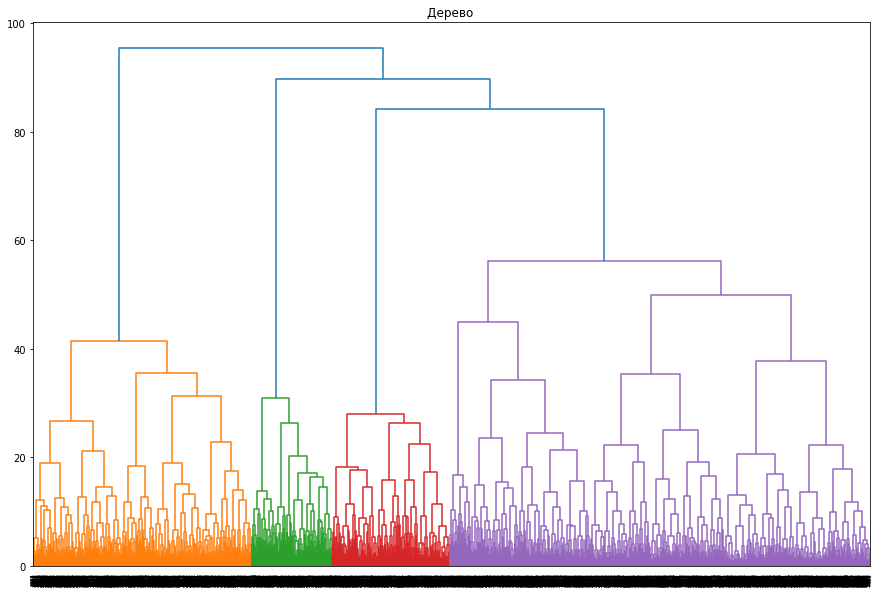

In [377]:
#Построение матрицы расстояний
linked = linkage(X_sc, method = 'ward')
# Визуализация дендограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дерево ')
plt.show() 

На основании графика можно выделить 4 кластера. По заданию примем число кластеров = 5.

### На основании алгоритма K-Means спрогнозируем кластеры клиентов.

In [378]:
# обучим модель кластеризации 
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)
df['cluster'] = labels

### Посмотрим на средние значения признаков для кластеров

In [379]:
# посмотрим на средние значения признаков для кластеров
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.499109,0.488571,0.505300,0.544202,0.523316
near_location,0.000000,0.995238,1.000000,1.000000,0.862694
partner,0.488414,0.955238,0.238516,0.250287,0.471503
promo_friends,0.076649,0.892381,0.059187,0.079219,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.032086,7.660952,2.819788,4.528129,4.777202
group_visits,0.235294,0.458095,0.000000,1.000000,0.427461
age,28.721925,29.543810,28.770318,29.536165,29.297927
avg_additional_charges_total,137.540009,155.861428,143.383993,148.088897,144.208179
lifetime,3.060606,4.380952,3.343640,3.761194,3.940415


Можно сказать,что во всех кластерах:

гендерное деление примерно 50/50;

средний возраст 28-30 лет;

суммарная выручка от других услуг фитнес-центра 131-161 у.е.;

время с момента первого обращения в фитнес-центр (lifetime) от 2,5 до 5 месяцев;

средняя частота посещений в неделю за все время с начала действия абонемента около 1-2 раза.;

###  Построим распределения признаков для кластеров.

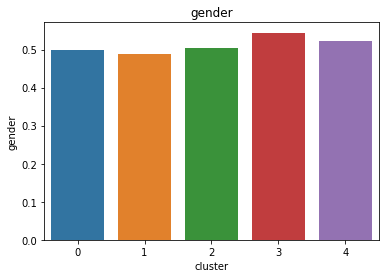

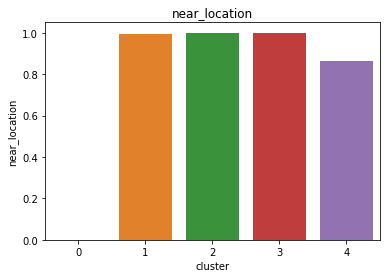

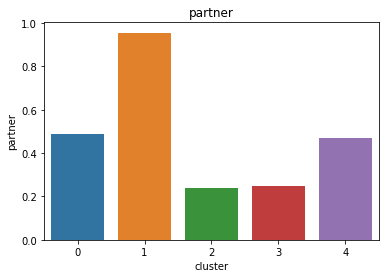

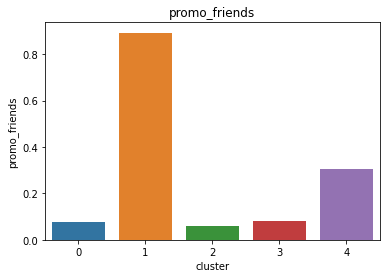

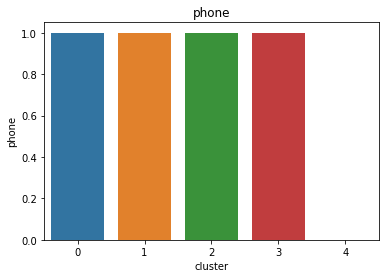

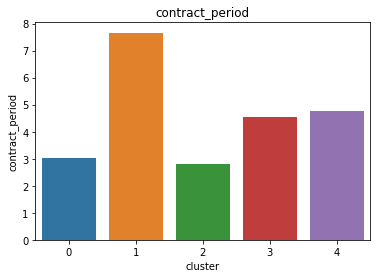

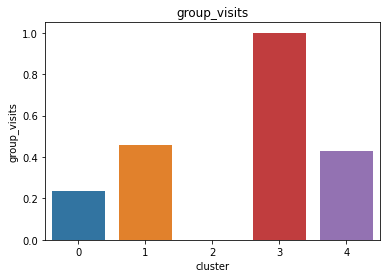

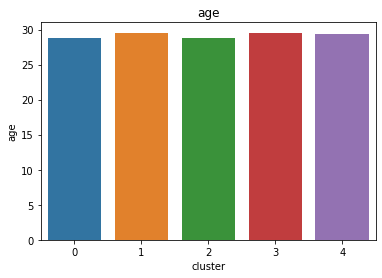

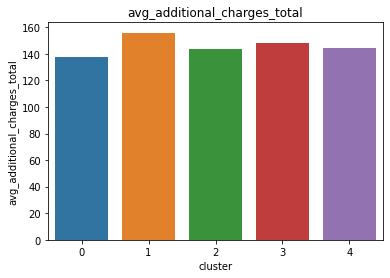

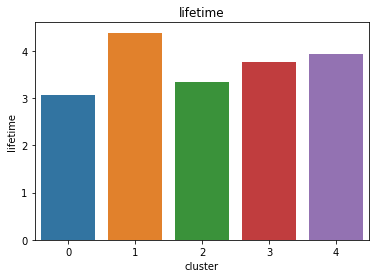

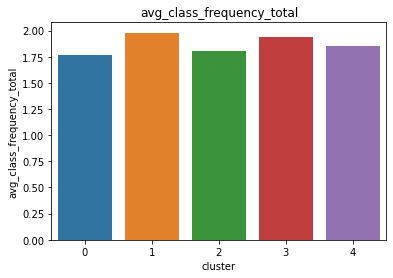

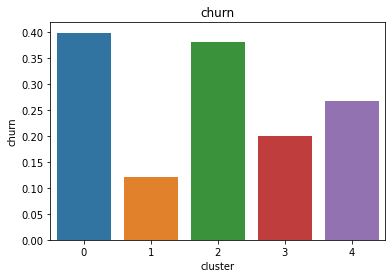

In [380]:
for i in df.groupby('cluster').mean().reset_index().drop('cluster', axis=1):
    sns.barplot(x='cluster', y=i, data=df.groupby('cluster').mean().reset_index());
    plt.title(i)
    plt.show();

В нулевой кластер вошли только клиенты которые проживают или работают в другом районе;

В четвертом клиенты которые не указали телефон;

Во втором те кто не посещает групповые занятия;

В первом кластере почти все клиенты сотрудник компании-партнёра клуба и пришли в рамках акции «приведи друга»;

В третьем все клиенты посещают групповые занятия.

### Для каждого полученного кластера посчитаем долю оттока

In [381]:
parts=df.groupby('cluster')['churn'].mean()
parts.sort_values(ascending=False)

cluster
0    0.399287
2    0.381625
4    0.266839
3    0.200918
1    0.120952
Name: churn, dtype: float64

In [382]:
fig = go.Figure(data=[go.Pie(labels=parts.index, values=parts.values, title='Доля оттока для кластеров')]);
fig.show() ;

## Выводы:

 **Портрет идеального среднестатистического клиента:**
 
 около 30 лет, 
 живет неподалеку от фитнес-центра, 
 регулярно ( 1-2 раза в неделю) посещает зал,
 посещает групповые занятия, 
 у него есть друзья, которые хотят в тот же фитнес-центр и есть скидки/бонусы по каким-то программам.
 есть абонемент на пол года или более.

**Факторы риска**

Чаще всего в отток попадают те, кто приходит попробовать позаниматься в зале, но что-то их не устраивет. 
Это клиенты либо живут не так близко, либо не посещают групповые занятия или пришли не по клиентской бонусной программе. 
Они берут абонемент на месяц, редко посещают тренировки.Не оставляют контактов т.е. изначально не стремятся стать постоянными клиентами.

**Рекомендации:**
 - Устанавливать сотрудничество с новыми компаниями;
 - Привлекать клиентов на групповые занятия, проводить открытые уроки.
 - Сделать бонусную программу: те кто больше занимается имеет большую скидку на последующий абонмент;
 - Провести рекламную компанию внутри района, где находится фитнес-центр.
 - Необходимо найти способы держать обратную связь с посетителями.